In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [3]:

# Load the CiteSeer dataset
dataset = Planetoid(root='/tmp/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())



Processing...
Done!


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First convolutional layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second convolutional layer
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)




In [5]:
# Set the device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
data = dataset[0].to(device)


In [6]:

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs



In [7]:
# Training loop
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')



Epoch: 010, Loss: 1.7304, Train Acc: 0.9333, Val Acc: 0.6160, Test Acc: 0.5980
Epoch: 020, Loss: 1.6066, Train Acc: 0.9500, Val Acc: 0.6580, Test Acc: 0.6500
Epoch: 030, Loss: 1.4551, Train Acc: 0.9500, Val Acc: 0.6960, Test Acc: 0.6800
Epoch: 040, Loss: 1.2906, Train Acc: 0.9417, Val Acc: 0.7220, Test Acc: 0.6930
Epoch: 050, Loss: 1.1452, Train Acc: 0.9500, Val Acc: 0.7060, Test Acc: 0.6860
Epoch: 060, Loss: 1.0129, Train Acc: 0.9667, Val Acc: 0.7180, Test Acc: 0.6970
Epoch: 070, Loss: 0.8555, Train Acc: 0.9667, Val Acc: 0.7160, Test Acc: 0.7050
Epoch: 080, Loss: 0.7666, Train Acc: 0.9750, Val Acc: 0.7200, Test Acc: 0.7010
Epoch: 090, Loss: 0.6443, Train Acc: 0.9750, Val Acc: 0.7140, Test Acc: 0.7020
Epoch: 100, Loss: 0.6586, Train Acc: 0.9750, Val Acc: 0.7140, Test Acc: 0.7050
Epoch: 110, Loss: 0.5500, Train Acc: 0.9750, Val Acc: 0.7240, Test Acc: 0.7090
Epoch: 120, Loss: 0.5610, Train Acc: 0.9750, Val Acc: 0.7160, Test Acc: 0.7130
Epoch: 130, Loss: 0.5127, Train Acc: 0.9750, Val Acc

In [8]:
# prompt: classification report of model

from sklearn.metrics import classification_report

# Get the model's predictions
y_pred = model(data).argmax(dim=1)

# Get the true labels
y_true = data.y

# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.33      0.44      0.37       264
           1       0.70      0.59      0.64       590
           2       0.74      0.72      0.73       668
           3       0.77      0.74      0.75       701
           4       0.80      0.82      0.81       596
           5       0.73      0.78      0.75       508

    accuracy                           0.70      3327
   macro avg       0.68      0.68      0.68      3327
weighted avg       0.72      0.70      0.71      3327



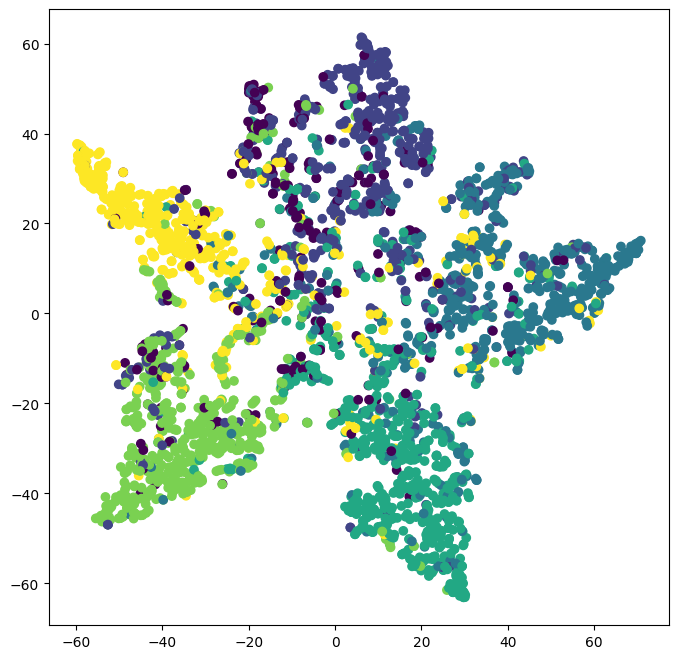

In [9]:
# prompt: extract model activation and use tSNE clustering

# Extract the model activation
model.eval()
out = model(data)
activations = out.detach().cpu().numpy()

# Perform tSNE clustering
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(activations)

# Plot the clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=data.y, cmap='viridis')
plt.show()


In [10]:
# prompt: relative cluster size comparison

# Calculate the number of data points in each cluster
cluster_sizes = [len(data.y[data.y == i]) for i in range(dataset.num_classes)]

# Calculate the relative cluster sizes
relative_cluster_sizes = [size / sum(cluster_sizes) for size in cluster_sizes]

# Print the relative cluster sizes
print(f"Relative cluster sizes: {relative_cluster_sizes}")


Relative cluster sizes: [0.0793507664562669, 0.17733694018635407, 0.2007814848211602, 0.21070033062819357, 0.17914036669672379, 0.15269011121130147]


In [11]:
# prompt: calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(activations, data.y)
print(f"Silhouette score: {silhouette_avg}")

# Calculate the Davies-Bouldin score
davies_bouldin = davies_bouldin_score(activations, data.y)
print(f"Davies-Bouldin score: {davies_bouldin}")

# Calculate the Calinski-Harabasz score
calinski_harabasz = calinski_harabasz_score(activations, data.y)
print(f"Calinski-Harabasz score: {calinski_harabasz}")


Silhouette score: 0.12278161942958832
Davies-Bouldin score: 2.2341752868867713
Calinski-Harabasz score: 471.3943422215246


###Poisoned CiteSeer after Augmentation

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.transforms as T
import random

# Load Citeseer dataset
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer', transform=NormalizeFeatures())

# Define data augmentation functions
def augment_features(data, noise_level=0.01):
    """Randomly perturb the node features."""
    noise = torch.randn_like(data.x) * noise_level
    data.x = data.x + noise
    return data

def augment_edges(data, drop_edge_rate=0.1, add_edge_rate=0.1):
    """Randomly drop and add edges."""
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Drop edges
    mask = torch.rand(num_edges) > drop_edge_rate
    edge_index = edge_index[:, mask]

    # Add edges
    num_add_edges = int(add_edge_rate * num_edges)
    add_edges = torch.randint(0, data.num_nodes, (2, num_add_edges))
    edge_index = torch.cat([edge_index, add_edges], dim=1)

    data.edge_index = edge_index
    return data

def augment_nodes(data, drop_node_rate=0.1):
    """Randomly drop nodes."""
    num_nodes = data.num_nodes
    mask = torch.rand(num_nodes) > drop_node_rate
    data.x = data.x[mask]
    data.y = data.y[mask]
    data.train_mask = data.train_mask[mask]
    data.val_mask = data.val_mask[mask]
    data.test_mask = data.test_mask[mask]
    data.num_nodes = mask.sum().item()

    # Adjust edge_index
    edge_index = data.edge_index
    node_map = torch.zeros(num_nodes, dtype=torch.long)
    node_map[mask] = torch.arange(mask.sum())
    edge_index = node_map[edge_index]
    data.edge_index = edge_index[:, edge_index[0] < data.num_nodes]

    return data

# Apply augmentations
data = dataset[0]
data = augment_features(data, noise_level=0.01)
data = augment_edges(data, drop_edge_rate=0.1, add_edge_rate=0.1)
data = augment_nodes(data, drop_node_rate=0.1)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define model, optimizer, and loss function
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        accs.append(correct / mask.sum().item())
    return accs

# Training loop
for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

print('Training complete')


Processing...
Done!


Epoch: 000, Loss: 1.7916, Train Acc: 0.4766, Val Acc: 0.0882, Test Acc: 0.1059
Epoch: 001, Loss: 1.7688, Train Acc: 0.7196, Val Acc: 0.1244, Test Acc: 0.1616
Epoch: 002, Loss: 1.7394, Train Acc: 0.7944, Val Acc: 0.1606, Test Acc: 0.1839
Epoch: 003, Loss: 1.7032, Train Acc: 0.8224, Val Acc: 0.1742, Test Acc: 0.2051
Epoch: 004, Loss: 1.6641, Train Acc: 0.8598, Val Acc: 0.1810, Test Acc: 0.2029
Epoch: 005, Loss: 1.6539, Train Acc: 0.8785, Val Acc: 0.1855, Test Acc: 0.2051
Epoch: 006, Loss: 1.5928, Train Acc: 0.8972, Val Acc: 0.1946, Test Acc: 0.2062
Epoch: 007, Loss: 1.5523, Train Acc: 0.9065, Val Acc: 0.1923, Test Acc: 0.2152
Epoch: 008, Loss: 1.5064, Train Acc: 0.9159, Val Acc: 0.2014, Test Acc: 0.2174
Epoch: 009, Loss: 1.4670, Train Acc: 0.9439, Val Acc: 0.2081, Test Acc: 0.2297
Epoch: 010, Loss: 1.4365, Train Acc: 0.9533, Val Acc: 0.2195, Test Acc: 0.2430
Epoch: 011, Loss: 1.3857, Train Acc: 0.9533, Val Acc: 0.2353, Test Acc: 0.2520
Epoch: 012, Loss: 1.3302, Train Acc: 0.9720, Val Acc

In [13]:
# prompt: classifcation report of model

# Get the model's predictions
y_pred = model(data).argmax(dim=1)

# Get the true labels
y_true = data.y

# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.21      0.25      0.23       240
           1       0.35      0.34      0.35       534
           2       0.52      0.47      0.50       597
           3       0.47      0.53      0.50       634
           4       0.54      0.63      0.58       533
           5       0.55      0.36      0.44       452

    accuracy                           0.45      2990
   macro avg       0.44      0.43      0.43      2990
weighted avg       0.46      0.45      0.45      2990



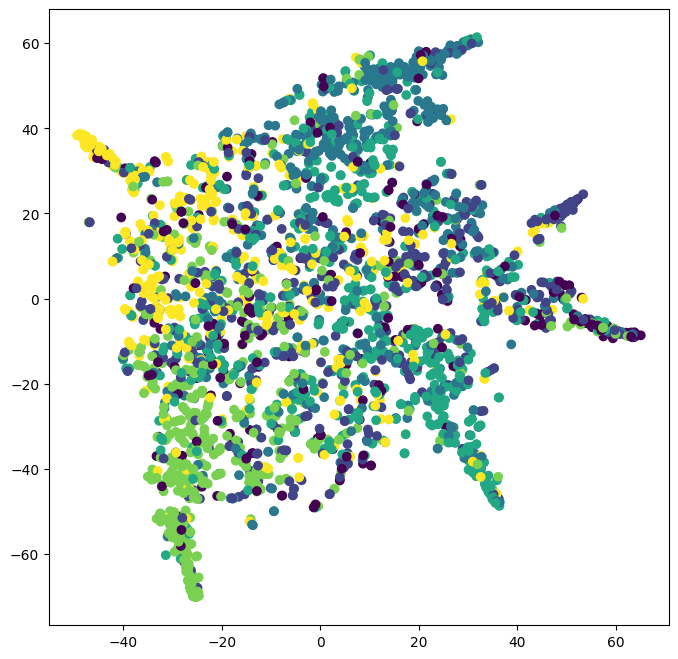

In [14]:
# prompt: extract model activation and use tSNE cluster

# Extract the model activation
model.eval()
out = model(data)
activations_p = out.detach().cpu().numpy()

# Perform tSNE clustering
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(activations_p)

# Plot the clusters
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=data.y, cmap='viridis')
plt.show()


In [15]:
# prompt: now calculate silhouette_score, davies_bouldin_score and calinski_harabasz_score

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score
silhouette_avg = silhouette_score(tsne_data, data.y)
print("Silhouette score:", silhouette_avg)

# Calculate Davies-Bouldin score
davies_bouldin_score_avg = davies_bouldin_score(tsne_data, data.y)
print("Davies-Bouldin score:", davies_bouldin_score_avg)

# Calculate Calinski-Harabasz score
calinski_harabasz_score_avg = calinski_harabasz_score(tsne_data, data.y)
print("Calinski-Harabasz score:", calinski_harabasz_score_avg)


Silhouette score: -0.03845093
Davies-Bouldin score: 19.32994378752692
Calinski-Harabasz score: 149.4339444753021


In [16]:
# prompt: also calculate relative cluster size

# Calculate relative cluster sizes
cluster_sizes = [len(data.y[data.y == i]) for i in range(dataset.num_classes)]
relative_cluster_sizes = [size / sum(cluster_sizes) for size in cluster_sizes]

# Print the relative cluster sizes
print(f"Relative cluster sizes: {relative_cluster_sizes}")


Relative cluster sizes: [0.0802675585284281, 0.17859531772575252, 0.19966555183946488, 0.2120401337792642, 0.1782608695652174, 0.15117056856187291]


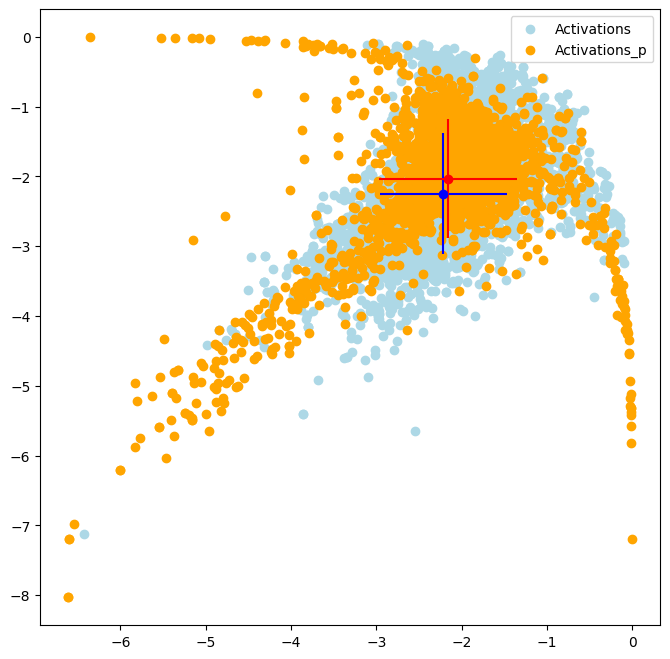

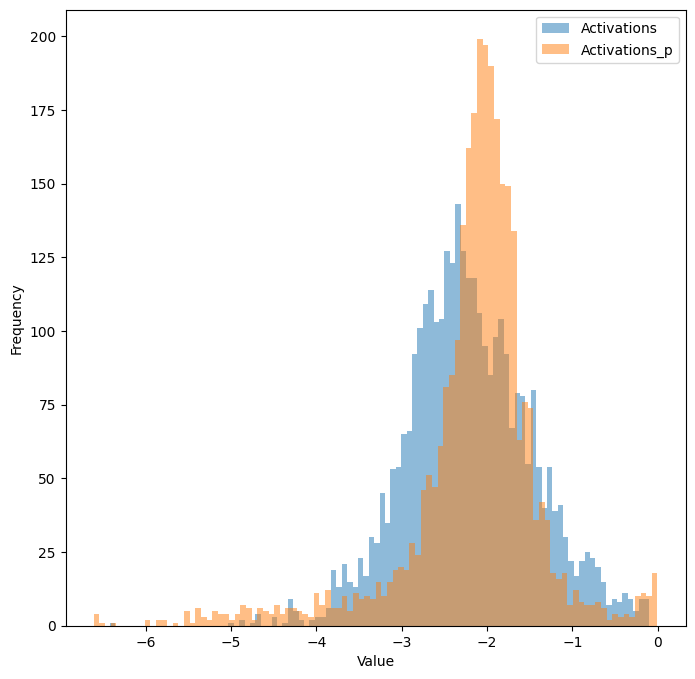

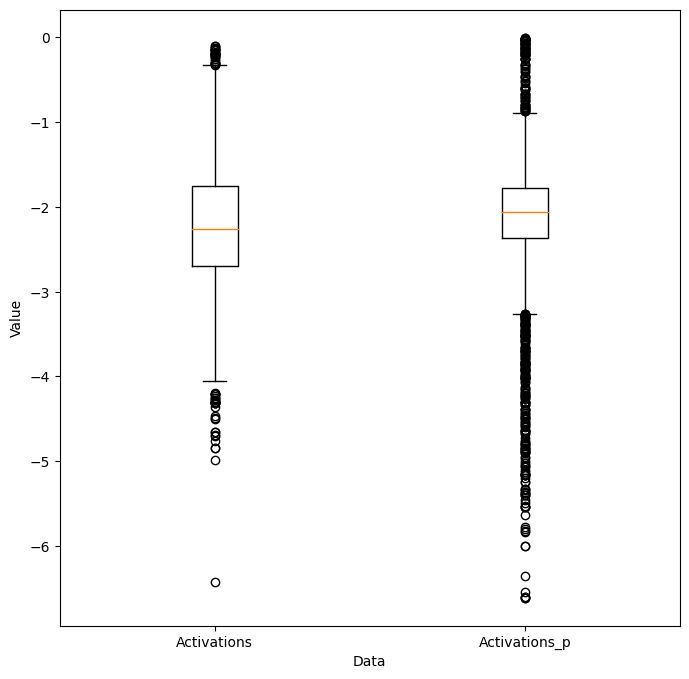

In [27]:
# prompt: Compare activations and activations_p both from the above model , suggest some graph , plot for comparision

# Calculate the mean and standard deviation of the activations and activations_p
mean_activations = activations.mean(axis=0)
std_activations = activations.std(axis=0)

mean_activations_p = activations_p.mean(axis=0)
std_activations_p = activations_p.std(axis=0)

# Create a scatter plot of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.scatter(activations[:, 0], activations[:, 1], c='lightblue', label='Activations')
plt.scatter(activations_p[:, 0], activations_p[:, 1], c='orange', label='Activations_p')

# Plot the mean and standard deviation of the activations and activations_p
plt.errorbar(mean_activations[0], mean_activations[1], xerr=std_activations[0], yerr=std_activations[1], fmt='o', c='blue')
plt.errorbar(mean_activations_p[0], mean_activations_p[1], xerr=std_activations_p[0], yerr=std_activations_p[1], fmt='o', c='red')

# Add a legend and show the plot
plt.legend()
plt.show()

# Create a histogram of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.hist(activations[:, 0], bins=100, alpha=0.5, label='Activations')
plt.hist(activations_p[:, 0], bins=100, alpha=0.5, label='Activations_p')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a boxplot of the activations and activations_p
plt.figure(figsize=(8, 8))
plt.boxplot([activations[:, 0], activations_p[:, 0]], labels=['Activations', 'Activations_p'])
plt.xlabel('Data')
plt.ylabel('Value')
plt.show()


In [ ]:
# prompt: I have two model one is poisoned and other is clean , now i want to find sensitvity of model to poisoned data

# Define the sensitivity metric
def sensitivity(clean_acc, poisoned_acc):
  return (clean_acc - poisoned_acc) / clean_acc

# Calculate the clean and poisoned accuracies
clean_acc = 0.70
poisoned_acc = 0.45 # Replace with the accuracy of the poisoned model

# Calculate the sensitivity
sensitivity = sensitivity(clean_acc, poisoned_acc)

# Print the sensitivity
print(f"Sensitivity: {sensitivity}")


Sensitivity: 0.3571428571428571


In [ ]:
# prompt: convert this sensitvity to percentagge

sensitivity_percentage = sensitivity * 100
print(f"Sensitivity: {sensitivity_percentage:.2f}%")

Sensitivity: 35.71%


In [ ]:
def calculate_poisoned_performance(C_clean, S, P):
    """
    Calculate the performance of the model when poisoned data is introduced.

    Parameters:
    C_clean (float): Performance metric of the clean model (e.g., accuracy, precision).
    S (float): Sensitivity of the model to poisoned data.
    P (float): Proportion of poisoned data.

    Returns:
    float: Performance metric of the model with poisoned data.
    """
    C_poison = C_clean * (1 + S * P)
    return C_poison

# Example usage:
C_clean = 0.70  # Performance of the model with clean data
S = 0.35        # Sensitivity of the model to poisoned data
P = 0.1        # Proportion of poisoned data

C_poison = calculate_poisoned_performance(C_clean, S, P)
print(f"Performance of the model with poisoned data: {C_poison}")


Performance of the model with poisoned data: 0.7244999999999999
